In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [5]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")[["Id","rsem.out.S442_NT"]]
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [6]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
print(len(genes_exp_df))
genes_exp_df.head(3)


23225


Id  rsem.out.S442_NT  geneId    chr    txStart      txEnd  geneName  \
0  C9orf152                 0  401546   chr9  112961844  112970439  C9orf152   
1     RPS11              4520    6205  chr19   49999690   50002965     RPS11   
2     ELMO2                14   63916  chr20   44994683   45035690     ELMO2   

   citationCount strand  union_geneId        geneType  \
0              5      -  union_401546  protein-coding   
1            149      +    union_6205  protein-coding   
2             47      -   union_63916  protein-coding   

                              geneDesc   cdsStart     cdsEnd  \
0  chromosome 9 open reading frame 152  112963227  112969859   
1                ribosomal protein S11   49999713   50002892   
2       engulfment and cell motility 2   44995998   45017838   

                                          exonStarts  \
0                                112961844,112969666   
1       49999690,50000450,50000776,50001173,50002768   
2  44994683,44994689,44997529,44999081,44999990,4...   

                                            exonEnds  
0                                112963754,112970439  
1       49999728,50000582,50000852,50001303,50002965  
2  44996199,44996199,44997607,44999164,45000098,4...

In [7]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "rsem.out.S442_NT"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end",
                  "rsem.out.S442_NT":"exp",
                 }

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [8]:
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

chrom  start    end strand  exp   size
0  chr1  11873  14409      +    0   2536
1  chr1  14361  29370      -   32  15009
2  chr1  69090  70008      +    0    918

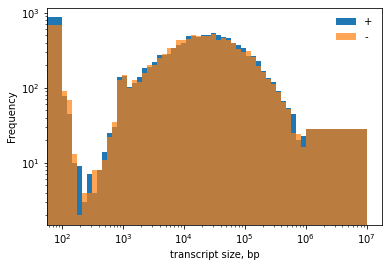

In [9]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

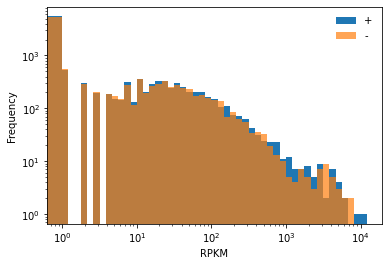

In [10]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
gdf[gdf["strand"]=="+"]["exp"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["exp"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("RPKM")
ax.legend(frameon=False)

In [11]:
exp_bin_edges = [0,.5,8,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

chrom   start     end strand  exp   size  gexp  gsize
0  chr1   11873   14409      +    0   2536    no  short
1  chr1   14361   29370      -   32  15009  high  short
2  chr1   69090   70008      +    0    918    no  short
3  chr1  134772  140566      -    0   5794    no  short
4  chr1  562759  564389      -    0   1630    no  short

gsize  short  long
gexp              
no      8737  2093
low     2317  1328
high    5315  2504

In [12]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [13]:
def extract_ins(df,
                fname,
                bins=3000,
                flip_by_strand=False,
                flip_sign=False,
                summary = "mean",
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes (or not) ...
    """
    if flip_by_strand:
        return np.asarray([
            bbi.fetch
                   (
                        fname,
                        chrom,
                        start,
                        end,
                        bins=bins,
                        missing=0.0,
                        oob=np.nan,
                        summary=summary,
                    )[:: (-1 if strand=="-" else 1) ] * (-1 if ( (strand=="-") and (flip_sign) ) else 1 )
            # flip in place for "-" genes and multiply by -1 if requested ...
          for chrom, start, end, strand, *_ in df.itertuples(index=False)
        ])
    else:
        return np.asarray([
            bbi.fetch
                   (
                        fname,
                        chrom,
                        start,
                        end,
                        bins=bins,
                        missing=0.0,
                        oob=np.nan,
                        summary=summary,
                    )
          for chrom, start, end, *_ in df.itertuples(index=False)
        ])


### TSS to TTS scaled profiles ...

In [14]:
# key features/signals that we want to extract for our genes ...
key_features = [ 
#                 'ins_CTCF',
#                 'ins_noCTCF',
#                  'ins_siCtr_CTCF',
#                  'ins_siCtr_noCTCF',
#                  'ins_siTAF_CTCF',
#                  'ins_siTAF_noCTCF',
#                  'ins_siDDX_CTCF',
#                  'ins_siDDX_noCTCF',
                 'ins_mutCtr_CTCF',
                 'ins_mutCtr_noCTCF',
                 'ins_mutTAF_CTCF',
                 'ins_mutTAF_noCTCF',
                 'ins_mutDDX_CTCF',
                 'ins_mutDDX_noCTCF',
                 "ctcf",
                 "noctcf",
#                 "polII",
                'ddx_CTCF',
                'taf5l_CTCF',
#                 'ddx_noCTCF',
                "Rloop_K562",
                'rad21_CTCF',
#                 'h3k27ac_r1',
#                 'h3k4_r1',
#                 'G4a_r2',
#                 'dnase-hap1',
                'mrna_ctcf',
               ]

### Extracting Meta-gene profiles of the key-features (insulations, Chip_Seq data etc)

#### Here we extract data for + and - genes separately and flip "-" genes to orient them same way as the "+" genes ...
#### using `extract_ins` function...

In [15]:
profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                    )
                                )

extracting ins_mutCtr_CTCF for the genes ...
extracting ins_mutCtr_noCTCF for the genes ...
extracting ins_mutTAF_CTCF for the genes ...
extracting ins_mutTAF_noCTCF for the genes ...
extracting ins_mutDDX_CTCF for the genes ...
extracting ins_mutDDX_noCTCF for the genes ...
extracting ctcf for the genes ...
extracting noctcf for the genes ...
extracting ddx_CTCF for the genes ...
extracting taf5l_CTCF for the genes ...
extracting Rloop_K562 for the genes ...
extracting rad21_CTCF for the genes ...
extracting mrna_ctcf for the genes ...


#### introduce categories of interest here `[("high","long"), ("no","long")]` ...

In [16]:
exp_size_cats = [("high","long"), ("low","long"), ("no","long")]

#### modify insulations profiles (normalize) right away ...

In [17]:
insulation_keys = [k for k in key_features if k.startswith("ins")]
for ins_feature in insulation_keys:
#     profiles_dict[ins_feature] = profiles_dict[ins_feature].to_dict()
    for key, ins_stack in profiles_dict[ins_feature].items():
        if key in exp_size_cats:
            l,w = ins_stack.shape
            flank_size = int(w*0.25)
            # get shoulders of the stack
            shoulder_idxs = np.r_[:flank_size,w-flank_size:w]
            profiles_dict[ins_feature][key] = ins_stack - \
                np.nanmean(
                    ins_stack[:,shoulder_idxs],
                    axis=1,
                    keepdims=True
                )


##### Free up some memory here - this notebook is rather heavy

In [18]:
# fill out some odf the categories with blanks - to save memory ...
for k in profiles_dict:
    profiles_dict[k][("low","short")] = np.nan
#     profiles_dict[k][("low","long")] = np.nan
    profiles_dict[k][("no","short")] = np.nan
    profiles_dict[k][("high","short")] = np.nan

#### add some manually create stacks here ...

In [19]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...

_tmp_profiles_dict = {}
for feature_name in ['CTCF_peaks_plus', 'CTCF_peaks_minus']:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = feature_name+".bb"
    _tmp_profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                        flip_sign=True,
                                        summary="mean"
                                    )
                                )

if key_features[-1] == "CTCF_peaks":
    key_features.pop()
feat_name = "CTCF_peaks"
key_features.append("CTCF_peaks")

profiles_dict["CTCF_peaks"] = {}
for key in gene_groups.groups.keys():
    profiles_dict["CTCF_peaks"][key] = _tmp_profiles_dict["CTCF_peaks_plus"][key] \
                                    - _tmp_profiles_dict["CTCF_peaks_minus"][key]

extracting CTCF_peaks_plus for the genes ...
extracting CTCF_peaks_minus for the genes ...


#### Add splicing samples ...

```python
[
    "splicing_mutDDX55-IAA_mutCtrl-IAA",
    "splicing_mutTAF5L-IAA_mutCtrl-IAA",
    "splicing_mutDDX55-IAA_mutCtrl-NT",
    "splicing_mutDDX55-NT_mutCtrl-NT",
    "splicing_mutTAF5L-IAA_mutCtrl-NT",
    "splicing_mutTAF5L-NT_mutCtrl-NT",
    "splicing_siDDX55-IAA_siCtrl-IAA",
    "splicing_siTAF5L-IAA_siCtrl-IAA",
    "splicing_siCtrl-IAA_siCtrl-NT",
    "splicing_siDDX55-IAA_siCtrl-NT",
    "splicing_siDDX55-NT_S442_siCtrl-NT",
    "splicing_siTAF5L-IAA_siCtrl-NT",
    "splicing_siTAF5L-NT_siCtrl-NT",
    "splicing_noCTCF_CTCF",
    "splicing_noCTCF_CTCF-noTIR1",
]
```

In [20]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
# feat_name = "SpliceDDX"
# feat_name_list = [
#                     "splicing_mutDDX55-IAA_mutCtrl-IAA",
#                     "splicing_mutDDX55-IAA_mutCtrl-NT",
#                     "splicing_mutDDX55-NT_mutCtrl-NT",
#                 ]


# feat_name_list = ["splicing_siDDX55-IAA_siCtrl-IAA",
# "splicing_siDDX55-IAA_siCtrl-NT",
# "splicing_siDDX55-NT_S442_siCtrl-NT",
# "splicing_siTAF5L-IAA_siCtrl-IAA",
# "splicing_siTAF5L-IAA_siCtrl-NT",
# "splicing_siTAF5L-NT_siCtrl-NT",
# "splicing_siCtrl-IAA_siCtrl-NT",
# "splicing_noCTCF_CTCF",
# "splicing_noCTCF_CTCF-noTIR1"]
feat_name_list = ["splicing_mutTAF5L-IAA_mutCtrl-IAA",
                "splicing_mutTAF5L-IAA_mutCtrl-NT",
                "splicing_mutTAF5L-NT_mutCtrl-NT",
                "splicing_mutDDX55-IAA_mutCtrl-IAA",
                "splicing_mutDDX55-IAA_mutCtrl-NT",
                "splicing_mutDDX55-NT_mutCtrl-NT",
                "splicing_noCTCF_CTCF",
                "splicing_noCTCF_CTCF-noTIR1"]

_tmp_profiles_dict = {}
for feature_name in feat_name_list:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = feature_name+".bb"
    _tmp_profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                        flip_sign=False,
                                        summary="mean"
                                    )
                                )

#     if key_features[-1] == feat_name:
#         key_features.pop()
    key_features.append(feature_name)

    profiles_dict[feature_name] = {}
    for key in gene_groups.groups.keys():
        profiles_dict[feature_name][key] = _tmp_profiles_dict[feature_name][key]

extracting splicing_mutTAF5L-IAA_mutCtrl-IAA for the genes ...
extracting splicing_mutTAF5L-IAA_mutCtrl-NT for the genes ...
extracting splicing_mutTAF5L-NT_mutCtrl-NT for the genes ...
extracting splicing_mutDDX55-IAA_mutCtrl-IAA for the genes ...
extracting splicing_mutDDX55-IAA_mutCtrl-NT for the genes ...
extracting splicing_mutDDX55-NT_mutCtrl-NT for the genes ...
extracting splicing_noCTCF_CTCF for the genes ...
extracting splicing_noCTCF_CTCF-noTIR1 for the genes ...


##### Free up some memory here - this notebook is rather heavy

In [21]:
del _tmp_profiles_dict
# fill out some odf the categories with blanks - to save memory ...
for k in profiles_dict:
    profiles_dict[k][("low","short")] = np.nan
#     profiles_dict[k][("low","long")] = np.nan
    profiles_dict[k][("no","short")] = np.nan
    profiles_dict[k][("high","short")] = np.nan

#### NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....

In [22]:
reordered_jdxs = OrderedDict()
for feature_key in exp_size_cats:
    stackup_for_sorting = profiles_dict["splicing_noCTCF_CTCF-noTIR1"][feature_key]
#     stackup_for_sorting = profiles_dict["CTCF_peaks"][feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = stackup_for_sorting.shape
    TSS_bin = int(width/3)
    TTS_bin = int(2*width/3)

    tmp_stack = {}
#     tmp_stack['ctcf_mean'] = np.nanmean(stackup_for_sorting[:,:TSS_bin-2],axis=1) \
#             - np.nanmean(stackup_for_sorting[:,TTS_bin-10:TTS_bin+20],axis=1)
#     tmp_stack['ctcf_mean'] = np.nanmean(stackup_for_sorting[:,TSS_bin:TTS_bin],axis=1)
    tmp_stack['splice_mean'] = np.nanmean(stackup_for_sorting[:,TSS_bin:TTS_bin],axis=1)
    
    _, _jjj = recursive_data_ordering(
        ks = [('splice_mean', "sort", 1, False)],
        idxs = np.arange( length ),
        data_dict = tmp_stack,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 2504 elements of splice_mean into 1 groups ...
sorting 1328 elements of splice_mean into 1 groups ...
sorting 2093 elements of splice_mean into 1 groups ...


In [23]:
titles = key_features

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
interpolations = {}
for s in key_features:
    if s.startswith("CTCF_"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (-0.2,0.2)
        cmps[s] = "coolwarm"
        norms[s] = None
        interpolations[s] = "bilinear"
    elif s.startswith("splicing_"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (0,0.01)
        cmps[s] = "Blues"
        norms[s] = None
        interpolations[s] = "bilinear"
    elif s.startswith("K562"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (0,0.5)
        cmps[s] = "Blues"
        norms[s] = None
        interpolations[s] = "bilinear"
    elif s.startswith("mrna"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (1,20)
        cmps[s] = cmap3
        norms[s] = matplotlib.colors.LogNorm(vmin=2.,vmax=10.)
        interpolations[s] = "nearest"
    else:
        bw_fnames[s] = samples[s]["fname"]
        binsizes[s] = samples[s]["binsize"]
        flanks[s] = samples[s]["flank"]
        limss[s] = samples[s]["crange"]
        cmps[s] = samples[s]["cmap"]
        norms[s] = samples[s]["norm"]
        interpolations[s] = "bilinear"
    
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.15,.1)
    cmps[s] = cmapYlGnBu_r

limss["ctcf"] = (0,0.6)
limss["noctcf"] = (0,0.6)
limss["Rloop_K562"] = (0,5)
limss['rad21_CTCF'] = (0,.3)
limss['h3k27ac_r1'] = (0,.1)
limss['G4a_r2'] = (0,20)
limss['ddx_CTCF'] = (0,.15)
limss['ddx_noCTCF'] = (0,.15)
# limss["mrna_ctcf"] = (0,5) # use matplotlib.colors.LogNorm(vmin=1.,vmax=20.)
# limss['rad21_noCTCF'] = (0,.3)



hmss = OrderedDict()

for feature_key in exp_size_cats:
    jjj = reordered_jdxs[feature_key]
    hmss[feature_key] = [ profiles_dict[_k][feature_key][jjj] for _k in key_features ]

_limss = [ limss[_k] for _k in key_features ]
_cmps = [ cmps[_k] for _k in key_features ]
_binsizes = [ binsizes[_k] for _k in key_features ]
_norms = [ norms[_k] for _k in key_features ]
_inters = [ interpolations[_k] for _k in key_features ]


#### Plotting the profiles ...

In [24]:
def plot_sss(
          hmss, # will become a dictionary now (or list) ...
          titles,
          limss,
          cmps,
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=False,
          interpolation=None,
          inch_per_1k_stack= 1.2, #inches per 1000 elements stackup ...
         ):
    # rewrite everyhting assuming hmss is a dict of stackup groups !
    # groups are plotted on top of each other ...
    
    # regardless - claculate number of axes for stackups ...
    num_stackup_groups = len(hmss)
    # pick in every stackup group and see how many are there
    num_stackups = max(len(hmss[k]) for k in hmss)
    num_rows = num_stackups
    # let's figure out - how tall is this stackup
    # get heights of stackups from each groups
    stackup_group_heights = [len(hmss[k][0]) for k in hmss]
    stackup_height = sum(stackup_group_heights)*inch_per_1k_stack/1_000
    figure_height = stackup_height + 2.5
    fig = plt.figure(
        figsize=(3.5*num_rows, figure_height),
        facecolor="white",
        constrained_layout=True
    )
    gs = fig.add_gridspec(
        num_stackup_groups+2,
        num_rows,
        width_ratios=[1]*num_rows,
        height_ratios = \
            [0.95*2.5/figure_height] + \
            [(_h/sum(stackup_group_heights))*(figure_height-2.5)/figure_height for _h in stackup_group_heights] + \
            [0.05*2.5/figure_height]
    )

    ax_profile = {}
    ax_stackup = {}
    ax_cbar = {}
    hmss_order = list( range(num_rows) )
    # replace following with the pre-defined column indexes ...
    for idx in hmss_order:
        ax_profile[idx] = fig.add_subplot(gs[0,idx])
        ax_stackup[idx] = [fig.add_subplot(gs[_i+1,idx]) for _i in range(num_stackup_groups)] # stackup groups ...
        ax_cbar[idx] = fig.add_subplot(gs[-1,idx])

    # turning some of the input parameters into "oredered" or labeled dicts ...
    if norms is None:
        norms = { _i:None for _i in hmss_order}
    else:
        norms = { _i:norms[i] for i,_i in enumerate(hmss_order)}
    if interpolation is None:
        interpolations = { _i:"nearest" for _i in hmss_order}
    else:
        interpolations = { _i:interpolation[_i] for _i in hmss_order}
    vlims = { _i:limss[i] for i,_i in enumerate(hmss_order)}
    titles = { _i:titles[i] for i,_i in enumerate(hmss_order)}
    if binsizes is None:
        binsizes = { _i:1 for _i in hmss_order}
    else:
        binsizes = { _i:binsizes[i] for i,_i in enumerate(hmss_order)}


    hm_arr = {}
    profile_hm = {}
    labels_dict = {}
    # for each group of stackups (vertically set)
    for group_id, k in enumerate(hmss):
        hm_arr[group_id] = {}
        profile_hm[group_id] = {}
        labels_dict[group_id] = {}
        # for every stackup in each group (horizontal set)
        for idx, hm in zip(hmss_order, hmss[k]):
            if fillmissing:
                X = hm[:]
                missing = ~np.isfinite(X)
                mu = np.nanmean(X, axis=0, keepdims=True) # axis 0 or 1 - rows or columns ?!
                hm_arr[group_id][idx] = np.where(missing, mu, X)
            else:
                hm_arr[group_id][idx] = hm[:]
            if norms[idx] is None:
                profile_hm[group_id][idx] = np.nanmean(hm_arr[group_id][idx],axis=0)
            else:
                lt_dat = np.log(hm_arr[group_id][idx])
                lt_dat = np.nan_to_num(lt_dat, copy=True, nan=np.nan, posinf=np.nan, neginf=np.nan)
                profile_hm[group_id][idx] = np.exp(np.nanmean(lt_dat, axis=0))
            labels_dict[group_id][idx] = k

    for idx, cmap in zip(hmss_order, cmps):
        # plot profiles from every group on a single common axis for profiles...
        for _i in range(num_stackup_groups):
            ax_profile[idx].plot(profile_hm[_i][idx], label=labels_dict[_i][idx])
        ax_profile[idx].set_yscale("linear" if norms[idx] is None else "log")
        ax_profile[idx].legend(frameon=False)
        # stackups for every group ...
        for _i in range(num_stackup_groups):
            stack_hm = ax_stackup[idx][_i].imshow(
                              hm_arr[_i][idx],
                              norm=norms[idx],
                              aspect="auto",
                              vmin=vlims[idx][0] if norms[idx] is None else None,
                              vmax=vlims[idx][1] if norms[idx] is None else None,
                              cmap=cmap,
                              interpolation=interpolations[idx],
            )
        # beautify ...
        group_id_beautify = 0
        first_bin = 0-.5
        center_bin = hm_arr[group_id_beautify][idx].shape[1]/2 - .5
        last_bin = hm_arr[group_id_beautify][idx].shape[1]-.5
        ax_profile[idx].set_xlim([first_bin, last_bin])
        ax_profile[idx].set_ylim(vlims[idx])
        ax_profile[idx].set_title(titles[idx])
        # human readable kb stuff:
        flank_in_kb = int((center_bin+.5)*binsizes[idx]/1000)
        flank_ticks = [first_bin, center_bin, last_bin]
        flank_ticklabels = [-flank_in_kb, 0, flank_in_kb]
        ax_profile[idx].set_xticks(flank_ticks)
        ax_profile[idx].set_xticklabels(flank_ticklabels)
        for _i in range(num_stackup_groups-1):
            ax_stackup[idx][_i].set_xticks([])
            ax_stackup[idx][_i].set_xticklabels([])
            ax_stackup[idx][_i].set_yticks([])
            ax_stackup[idx][_i].set_yticklabels([])
        # bottom one - show ticks for now ...
        _i = num_stackup_groups-1
        ax_stackup[idx][_i].set_xticks(flank_ticks)
        ax_stackup[idx][_i].set_xticklabels(flank_ticklabels)
        ax_stackup[idx][_i].set_yticks([])
        ax_stackup[idx][_i].set_yticklabels([])
        plt.colorbar(stack_hm,cax=ax_cbar[idx],orientation="horizontal")
        
    return None


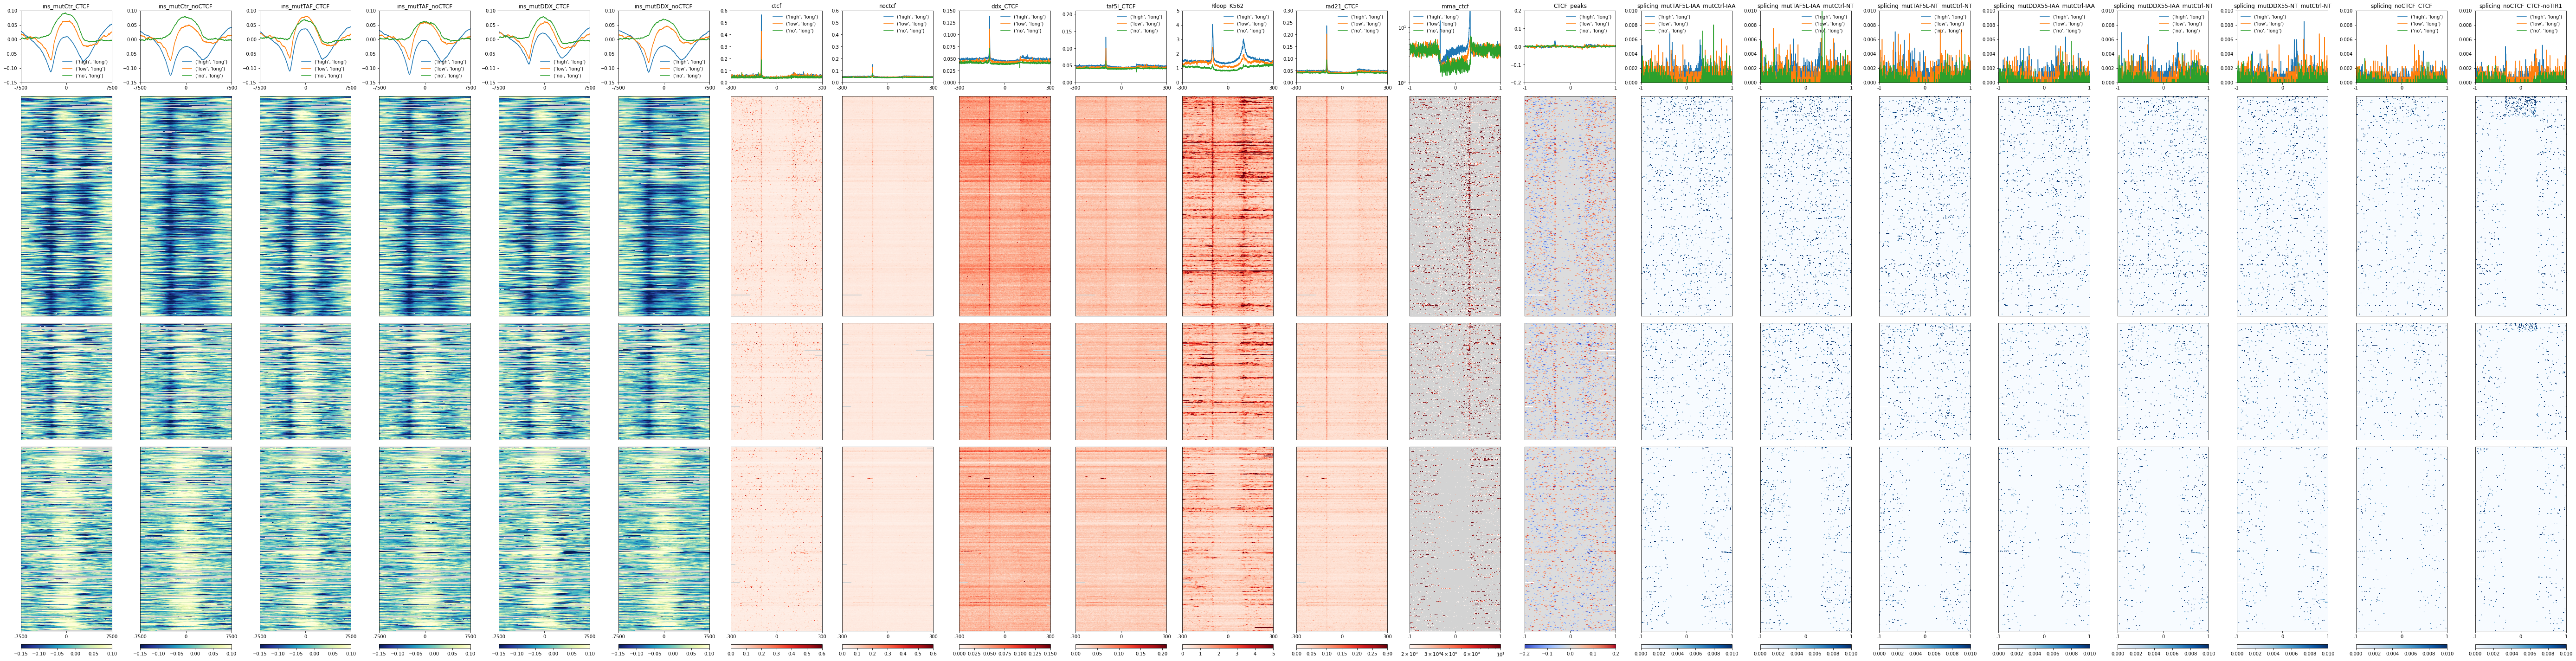

In [25]:
# ordered by the gene size ...
plot_sss( hmss = hmss,
          titles = titles,
          limss = _limss,
          cmps = _cmps,
          norms=_norms,
          binsizes=_binsizes,
          labels=None,
          fillmissing=False,
          interpolation=_inters,
          inch_per_1k_stack = 2.9,
         )

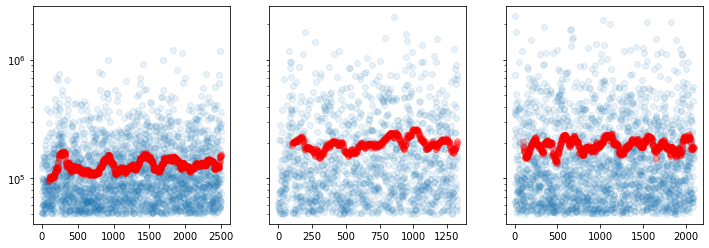

In [26]:
###############
# try adding a plpot controlling the size of the gene on the side of the stackups ...
################
f,axs = plt.subplots(1,3,figsize=(12,4),sharey=True)

ax = axs[0]
combo_key = ("high","long")
_jjj = reordered_jdxs[combo_key]
gene_groups.get_group(combo_key).iloc[_jjj]["size"].reset_index(drop=True).plot(ax=ax,marker="o",linewidth=0,alpha=0.1)
gene_groups.get_group(combo_key).iloc[_jjj]["size"].reset_index(drop=True).rolling(window=100).mean().plot(ax=ax,marker="o",linewidth=0,alpha=0.1,color="red")
ax.set_yscale("log")

ax = axs[1]
combo_key = ("low","long")
_jjj = reordered_jdxs[combo_key]
gene_groups.get_group(combo_key).iloc[_jjj]["size"].reset_index(drop=True).plot(ax=ax,marker="o",linewidth=0,alpha=0.1)
gene_groups.get_group(combo_key).iloc[_jjj]["size"].reset_index(drop=True).rolling(window=100).mean().plot(ax=ax,marker="o",linewidth=0,alpha=0.1,color="red")
ax.set_yscale("log")

ax = axs[2]
combo_key = ("no","long")
_jjj = reordered_jdxs[combo_key]
gene_groups.get_group(combo_key).iloc[_jjj]["size"].reset_index(drop=True).plot(ax=ax,marker="o",linewidth=0,alpha=0.1)
gene_groups.get_group(combo_key).iloc[_jjj]["size"].reset_index(drop=True).rolling(window=100).mean().plot(ax=ax,marker="o",linewidth=0,alpha=0.1,color="red")
ax.set_yscale("log")